In [ ]:
from IPython.display import clear_output
! pip install accelerate==0.20.3 -U
! pip install git+https://github.com/simonzhang00/ripser-plusplus.git
! pip install git+https://github.com/IlyaTrofimov/RTD.git
clear_output()
!git clone https://github.com/mklabunde/resi.git
!pip install loguru
!pip install git+https://github.com/KhrulkovV/geometry-score.git
!pip install git+https://github.com/xgfs/imd.git
!pip install gudhi
clear_output()
!pip install -U lightautoml
!pip install catboost
clear_output()

In [ ]:
import sys
sys.path.append('/content/resi/')

import torch
import rtd
from rtd.barcodes import h1sum, calc_embed_dist
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import pickle

from repsim.measures import ALL_MEASURES
from repsim.measures import FUNCTIONAL_SIMILARITY_MEASURES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import timedelta
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import pickle
device = torch.device('cuda')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Получение метрик

мои метрики

In [ ]:
def find_nearest_neighbors(embeddings, k):
    """
    Находит k ближайших соседей для каждого объекта в наборе эмбеддингов.

    Args:
        embeddings (torch.Tensor): Матрица эмбеддингов (n_objects, embedding_dim).
        k (int): Количество ближайших соседей.

    Returns:
        torch.Tensor: Матрица размеров (n_objects, k), где указаны индексы ближайших соседей.
    """
    distances = torch.cdist(embeddings, embeddings)  # Вычисляем матрицу расстояний
    indices = torch.argsort(distances, dim=1)  # Сортируем по возрастанию расстояний
    return indices[:, 1:k+1]  # Пропускаем сам объект (индекс 0) и берем k соседей

def my_neighbour_metric_1(X, Y, k= 5):
    n_objects = X.shape[0]
    nbh_1 = find_nearest_neighbors(X, k)
    nbh_2 = find_nearest_neighbors(Y, k)

    matches = 0
    for obj in range(n_objects):
            # Сравниваем списки ближайших соседей
            neighbors_1 = set(nbh_1[obj].tolist())
            neighbors_2 = set(nbh_2[obj].tolist())
            matches += len(neighbors_1.intersection(neighbors_2))/k

    return matches / n_objects

def my_neighbour_metric_2(X, Y, k= 5):
    n_objects = X.shape[0]
    nbh_1 = find_nearest_neighbors(X, k)
    nbh_2 = find_nearest_neighbors(Y, k)

    matches = 0
    for obj in range(n_objects):
            # Сравниваем списки ближайших соседей
            neighbors_1 = set(nbh_1[obj].tolist())
            neighbors_2 = set(nbh_2[obj].tolist())
            matches += len(neighbors_1.intersection(neighbors_2)) / len(neighbors_1.union(neighbors_2))

    return matches / n_objects

In [ ]:
def extract_upper_triangle(matrix):
    """
    Извлекает верхний треугольник матрицы (без диагонали).
    """
    n = matrix.shape[0]
    indices = torch.triu_indices(n, n, offset=1)
    return matrix[indices[0], indices[1]]

def compute_correlation(distances1, distances2):
    """
    Вычисляет корреляцию между двумя векторами расстояний.
    """
    mean1, mean2 = distances1.mean(), distances2.mean()
    centered1, centered2 = distances1 - mean1, distances2 - mean2
    covariance = (centered1 * centered2).sum() / len(distances1)
    std1, std2 = distances1.std(), distances2.std()
    return covariance / (std1 * std2)

def my_correlation_metric(X, Y):
    distance_1 = extract_upper_triangle(torch.cdist(X, X))
    distance_2 = extract_upper_triangle(torch.cdist(Y, Y))
    metric = compute_correlation(distance_1, distance_2)
    return metric.item()

In [ ]:
def rtd1(cl1, cl2, pdist_device = 'cuda:0'):
    return h1sum(calc_embed_dist(cl1, cl2, pdist_device = pdist_device)), h1sum(calc_embed_dist(cl2, cl1, pdist_device = pdist_device))

def rtd_mine(cl1, cl2, pdist_device = 'cuda:0', trials = 10, batch = 500):

    assert cl1.shape[0] == cl2.shape[0]
    batch = min(batch, cl1.shape[0])

    rtd_avg = 0
    h1sum_1_avg = 0
    h1sum_2_avg = 0

    for i in range(trials):
        rnd_idx = list(range(cl1.shape[0]))
        np.random.shuffle(rnd_idx)
        rnd_idx = rnd_idx[:batch]
        h1sum_1, h1sum_2 = rtd1(cl1[rnd_idx], cl2[rnd_idx], pdist_device = pdist_device)
        h1sum_1_avg += h1sum_1
        h1sum_2_avg += h1sum_2
        rtd_avg += (h1sum_1 + h1sum_2)/2

    return rtd_avg / trials, h1sum_1_avg / trials, h1sum_2_avg / trials

In [ ]:
# Предварительная загрузка данных в память
from tqdm import tqdm

data_local = []
for i in tqdm(range(1, 43)):
    if i ==19:
      continue
    train_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_A_{i}.csv').iloc[:,1:]
    train_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_B_{i}.csv').iloc[:,1:]

    embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    if (len(embed_columns)!=256) or (len(embed_columns_B)!=256):
      continue
    test_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_A_{i}.csv').iloc[:,1:]
    test_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_B_{i}.csv').iloc[:,1:]

    train_A = train_A.dropna(subset = ['gender'])
    test_A = test_A.dropna(subset = ['gender'])
    train_B = train_B.dropna(subset = ['gender'])
    test_B = test_B.dropna(subset = ['gender'])

    data_local.append((train_A, train_B, test_A, test_B))

    # embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    # embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    # X_train_A = train_A[embed_columns].values
    # X_train_B = train_B[embed_columns_B].values
    # y_train = train_A['gender'].values
    # X_test_A = test_A[embed_columns].values
    # X_test_B = test_B[embed_columns_B].values
    # y_test = test_A['gender'].values

    # data_local.append((X_train_A, X_test_A, X_train_B, X_test_B, y_train, y_test))

100%|██████████| 42/42 [01:11<00:00,  1.69s/it]


In [ ]:
n = len(data_local)
n

27

In [ ]:
task = Task('binary')
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'gender'
roles = {
    'target': TARGET_NAME,
    'drop': ['customer_id']
}

In [ ]:
def compare_embeddings(emb1_train, emb1_test, emb2_train, emb2_test, calc_emb2 = True):

    # Метрики для оценки
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": f1_score,
        "ROC-AUC": roc_auc_score
    }
    y_test = emb2_test['gender'].values
    # Результаты
    results = {}

    # Обучаем и оцениваем на первом наборе эмбеддингов
    automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
    out_of_fold_predictions = automl.fit_predict(emb1_train, roles = roles, verbose = 0).data[:, 0]
    y_proba = automl.predict(emb1_test).data[:, 0]
    y_pred = (y_proba>0.5).astype(int)


    # Вычисляем метрики
    results["emb_1"] = {
        metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }

    # Обучаем и оцениваем на втором наборе эмбеддингов
    if calc_emb2:
        # Обучаем и оцениваем на первом наборе эмбеддингов
        automl = TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )
        out_of_fold_predictions = automl.fit_predict(emb2_train, roles = roles, verbose = 0).data[:, 0]
        y_proba = automl.predict(emb2_test).data[:, 0]
        y_pred = (y_proba>0.5).astype(int)


        # Вычисляем метрики
        results["emb_2"] = {
            metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
            for metric_name, metric_func in metrics.items()
        }



    # Создание новых наборов эмбеддингов
    # Конкатенация
    scnd = emb2_train.iloc[:, :-2]
    scnd.columns = [str(i) for i in range(256)]
    emb_concat_train = pd.concat([emb1_train, scnd], axis = 1)

    scnd = emb2_test.iloc[:, :-2]
    scnd.columns = [str(i) for i in range(256)]
    emb_concat_test = pd.concat([emb1_test, scnd], axis = 1)

    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Сумма
      emb_sum_train = emb1_train + emb2_train
      emb_sum_test = emb1_test + emb2_test
      emb_sum_train['gender'] = emb_sum_train['gender'].apply(lambda x: 1 if x ==2 else x)
      emb_sum_test['gender'] = emb_sum_test['gender'].apply(lambda x: 1 if x ==2 else x)

    # Обучаем и оцениваем на конкатенированном наборе эмбеддингов
    automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
    out_of_fold_predictions = automl.fit_predict(emb_concat_train, roles = roles, verbose = 0).data[:, 0]
    y_proba = automl.predict(emb_concat_test).data[:, 0]
    y_pred = (y_proba>0.5).astype(int)

    # Вычисляем метрики
    results["concat_emb"] = {
        metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }
    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Обучаем и оцениваем на сумме эмбеддингов
          automl = TabularAutoML(
          task = task,
          timeout = TIMEOUT,
          cpu_limit = N_THREADS,
          reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
      )
          out_of_fold_predictions = automl.fit_predict(emb_sum_train, roles = roles, verbose = 0).data[:, 0]
          y_proba = automl.predict(emb_sum_test).data[:, 0]
          y_pred = (y_proba>0.5).astype(int)

      # Вычисляем метрики
          results["sum_emb"] = {
              metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
              for metric_name, metric_func in metrics.items()
          }

    return results

In [ ]:
def compare_emb_similarity(A, B, all_metrs = True):
    res = {}
    P = torch.tensor(A, device = device)
    Q = torch.tensor(B, device = device)
    rtd, h1, h2 = rtd_mine(P, Q, pdist_device = device)
    res['rtd'] = rtd
    res['h1sum_1'] = h1
    res['h1sum_2'] = h2
    #мои метрики
    res['my_correlation_metric'] = my_correlation_metric(P, Q)
    res['my_neighbour_metric_1'] = my_neighbour_metric_1(P,Q)
    res['my_neighbour_metric_2'] = my_neighbour_metric_2(P,Q)

    if all_metrs:
      # ALL_MEASURES
      for name, cls in ALL_MEASURES.items():
        if name == 'GeometryScore':
          continue
        try:
          value = cls(A, B, shape = 'nd')
          res[name] = value
        except:
          res[name] = None

      #FUNCTIONAL_SIMILARITY_MEASURES
      for name, cls in FUNCTIONAL_SIMILARITY_MEASURES.items():
        try:
          value = cls(A, B)
          res[name] = value
        except:
          res[name] = None

    return res

In [ ]:
try:
  with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
except:
  results = {}

In [ ]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23])

In [ ]:
for i, (train_A, train_B, test_A, test_B) in enumerate(data_local[23:], 24):
    if i == 19:
      continue
    results[i] = {}
    print(f'Эксперимент {i}')

    #Сравниваем 2 набора по качеству
    res_comp = compare_embeddings(train_A, test_A, train_B, test_B)
    clear_output()
    print(res_comp)
    results[i]['compare_embs'] = res_comp

    # P = train_A.iloc[:, :-2].values
    # Q = train_B.iloc[:, :-2].values
    # #Сравниваем 2 набора по близости
    # res_sim = compare_emb_similarity(P, Q)

    # print(res_sim)
    # results[i]['compare_similarity'] = res_sim


    with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_2.pickle', 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'emb_1': {'Accuracy': 0.7466585662211421, 'F1 Score': 0.6927044952100221, 'ROC-AUC': 0.8272443983901003}, 'emb_2': {'Accuracy': 0.5650060753341434, 'F1 Score': 0.0, 'ROC-AUC': 0.5112017180272722}, 'concat_emb': {'Accuracy': 0.74726609963548, 'F1 Score': 0.6904761904761905, 'ROC-AUC': 0.8230236679281552}, 'sum_emb': {'Accuracy': 0.7466585662211421, 'F1 Score': 0.687171792948237, 'ROC-AUC': 0.8201958310806752}}


In [ ]:
from google.colab import runtime
runtime.unassign()

# Анализ результатов

In [ ]:
# здесь метрики сравнения эмбедов
with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_1.pickle', 'rb') as handle:
    results_sim = pickle.load(handle)
#здесь метрики лама
with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_2.pickle', 'rb') as handle:
    results_lama = pickle.load(handle)

In [ ]:
rng = list(range(1, 28))
rng.remove(19)
all_metrics = results_sim[1]['compare_similarity'].keys()

In [ ]:
def get_corr_matrix(metric_name, concat_type = 'concat', clean_metric = True):
  accuracy_emb_1 = np.array([results_lama[i]['compare_embs']['emb_1'][metric_name] for i in rng])
  accuracy_emb_2= np.array([results_lama[i]['compare_embs']['emb_2'][metric_name] for i in rng])
  accuracy_concat = np.array([results_lama[i]['compare_embs']['concat_emb'][metric_name] for i in rng])
  accuracy_sum = np.array([results_lama[i]['compare_embs']['sum_emb'][metric_name] if results_lama[i]['compare_embs'].get('sum_emb') else np.nan for i in rng])

  if concat_type == 'concat':
    delta = accuracy_concat - np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)
  elif concat_type == 'sum':
    delta = accuracy_sum - np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)

  if clean_metric:
    # очищенная метрика
    mn = np.vstack([accuracy_emb_1, accuracy_emb_2]).min(axis = 0)
    mx = np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)
    X = np.column_stack((mn, mx))
    model = LinearRegression()
    model.fit(X, delta)
    predicted_delta = model.predict(X)
    delta = delta - predicted_delta

  correlations = pd.DataFrame()
  for i, metr_name in enumerate(all_metrics):
    metric = np.array([results_sim[i]['compare_similarity'][metr_name] for i in rng])
    try:
      coef = np.corrcoef(metric, delta)[0,1]
    except:
      coef = np.nan
    correlations.loc[i, 'metric'] = metr_name
    correlations.loc[i, 'correlation'] = coef
  df = correlations.sort_values('correlation', ascending = False)
  return df

In [ ]:
df1 = get_corr_matrix('ROC-AUC')

In [ ]:
df2 = get_corr_matrix('ROC-AUC', concat_type = 'sum')

df1 и df2 практически одно и то же

In [ ]:
df1

,metric,correlation
19,OrthogonalAngularShapeMetricCentered,0.361715
21,PermutationProcrustes,0.358314
20,OrthogonalProcrustesCenteredAndNormalized,0.357131
24,RSMNormDifference,0.326474
2,h1sum_2,0.326416
22,ProcrustesSizeAndShapeDistance,0.324690
29,JSD,0.263240
13,Gulp,0.210758
25,ConcentricityDifference,0.196528
26,MagnitudeDifference,0.121348


In [ ]:
df2

,metric,correlation
19,OrthogonalAngularShapeMetricCentered,0.290789
20,OrthogonalProcrustesCenteredAndNormalized,0.289547
13,Gulp,0.203173
2,h1sum_2,0.161714
0,rtd,0.150624
21,PermutationProcrustes,0.147303
29,JSD,0.129037
22,ProcrustesSizeAndShapeDistance,0.105387
30,Disagreement,0.094124
24,RSMNormDifference,0.078386


Видим в обоих случаях отрицательную корреляцию с метрикой корреляции

Accuracy

In [ ]:
get_corr_matrix('Accuracy')

,metric,correlation
21,PermutationProcrustes,0.215549
22,ProcrustesSizeAndShapeDistance,0.171989
6,PWCCA,0.165051
2,h1sum_2,0.161902
24,RSMNormDifference,0.161686
25,ConcentricityDifference,0.150306
26,MagnitudeDifference,0.140156
14,LinearRegression,0.124863
29,JSD,0.123959
11,EigenspaceOverlapScore,0.059410


In [ ]:
get_corr_matrix('Accuracy', concat_type = 'sum')

,metric,correlation
14,LinearRegression,0.183622
2,h1sum_2,0.176150
6,PWCCA,0.173654
7,SVCCA,0.066020
18,AlignedCosineSimilarity,0.061932
9,SoftCorrelationMatch,0.041626
26,MagnitudeDifference,0.029349
20,OrthogonalProcrustesCenteredAndNormalized,0.020056
8,HardCorrelationMatch,0.019233
13,Gulp,0.018309


F1-score

In [ ]:
get_corr_matrix('F1 Score')

,metric,correlation
21,PermutationProcrustes,0.202023
29,JSD,0.198596
24,RSMNormDifference,0.177591
22,ProcrustesSizeAndShapeDistance,0.167659
17,SecondOrderCosineSimilarity,0.150558
20,OrthogonalProcrustesCenteredAndNormalized,0.130295
19,OrthogonalAngularShapeMetricCentered,0.129250
2,h1sum_2,0.126378
25,ConcentricityDifference,0.088715
13,Gulp,0.087424


In [ ]:
get_corr_matrix('F1 Score', concat_type = 'sum')

,metric,correlation
29,JSD,0.382080
21,PermutationProcrustes,0.370401
0,rtd,0.357046
13,Gulp,0.295497
22,ProcrustesSizeAndShapeDistance,0.293402
26,MagnitudeDifference,0.217973
19,OrthogonalAngularShapeMetricCentered,0.198166
20,OrthogonalProcrustesCenteredAndNormalized,0.197688
25,ConcentricityDifference,0.189095
18,AlignedCosineSimilarity,0.181731


# Преобразование по метрике

my_correlation_metric

In [ ]:
def extract_upper_triangle(matrix):
    """Извлекает верхний треугольник матрицы (без диагонали)."""
    n = matrix.shape[0]
    indices = torch.triu_indices(n, n, offset=1)
    return matrix[indices[0], indices[1]]

def differentiable_correlation(a, b, eps=1e-6):
    """Вычисляет дифференцируемую корреляцию Пирсона."""
    a = a - a.mean()
    b = b - b.mean()
    norm_a = a / (a.norm() + eps)
    norm_b = b / (b.norm() + eps)
    return (norm_a * norm_b).sum()

def my_differentiable_metric(X, Y):
    """Дифференцируемая версия корреляционной метрики."""
    dist_X = extract_upper_triangle(torch.cdist(X, X, p=2))
    dist_Y = extract_upper_triangle(torch.cdist(Y, Y, p=2))
    return differentiable_correlation(dist_X, dist_Y)

In [ ]:
import torch.nn as nn

class EmbeddingTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.double()

    def forward(self, X):
        return self.model(X)

In [ ]:
# Предварительная загрузка данных в память
from tqdm import tqdm

data_pairs = []
for i in tqdm(range(1, 43)):
    if i ==19:
      continue
    train_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_A_{i}.csv').iloc[:,1:]
    train_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_B_{i}.csv').iloc[:,1:]

    embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    if (len(embed_columns)!=256) or (len(embed_columns_B)!=256):
      continue

    train_A = train_A.dropna(subset = ['gender'])
    train_B = train_B.dropna(subset = ['gender'])

    X_train_A = torch.tensor(train_A[embed_columns].values, device=device)
    X_train_B = torch.tensor(train_B[embed_columns_B].values, device=device)

    data_pairs.append((X_train_A, X_train_B))

100%|██████████| 42/42 [01:07<00:00,  1.61s/it]


In [ ]:
len(data_pairs), data_pairs[0][0].shape

(27, torch.Size([6741, 256]))

In [ ]:
n = len(data_pairs)

In [ ]:
model = EmbeddingTransformer(input_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Теперь в цикле обучения используем data_pairs из памяти
for epoch in range(4):
    total_loss = 0
    for X, Y in data_pairs:
        optimizer.zero_grad()
        X_transformed = model(X)
        loss = my_differentiable_metric(X_transformed, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(data_pairs)}")

Epoch 0, Loss: 0.24287048596425811
Epoch 1, Loss: 0.09496931340858045
Epoch 2, Loss: 0.030553625710410405
Epoch 3, Loss: -0.0061282305685792056


дальше уже получается отрицаательная корреляция

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_emb_modality/EmbeddingTransformer_lama_1.pt'
torch.save(model.state_dict(), PATH)

# Анализ преобразования

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_emb_modality/EmbeddingTransformer_lama_1.pt'

model = EmbeddingTransformer(input_dim=256).to(device)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

EmbeddingTransformer(
  (model): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
)

In [ ]:
# Предварительная загрузка данных в память
from tqdm import tqdm

data_local = []
for i in tqdm(range(1, 43)):
    if i ==19:
      continue
    train_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_A_{i}.csv').iloc[:,1:]
    train_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_B_{i}.csv').iloc[:,1:]

    embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    if (len(embed_columns)!=256) or (len(embed_columns_B)!=256):
      continue
    test_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_A_{i}.csv').iloc[:,1:]
    test_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_B_{i}.csv').iloc[:,1:]

    train_A = train_A.dropna(subset = ['gender'])
    test_A = test_A.dropna(subset = ['gender'])
    train_B = train_B.dropna(subset = ['gender'])
    test_B = test_B.dropna(subset = ['gender'])

    data_local.append((train_A, train_B, test_A, test_B))

100%|██████████| 42/42 [06:02<00:00,  8.64s/it]


In [ ]:
task = Task('binary')
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'gender'
roles = {
    'target': TARGET_NAME,
    'drop': ['customer_id']
}

In [ ]:
def compare_embeddings(emb1_train, emb1_test, emb2_train, emb2_test, calc_emb2 = True):

    # Метрики для оценки
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": f1_score,
        "ROC-AUC": roc_auc_score
    }
    y_test = emb2_test['gender'].values
    # Результаты
    results = {}

    # Обучаем и оцениваем на первом наборе эмбеддингов
    automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
    out_of_fold_predictions = automl.fit_predict(emb1_train, roles = roles, verbose = 0).data[:, 0]
    y_proba = automl.predict(emb1_test).data[:, 0]
    y_pred = (y_proba>0.5).astype(int)


    # Вычисляем метрики
    results["emb_1"] = {
        metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }

    # Обучаем и оцениваем на втором наборе эмбеддингов
    if calc_emb2:
        # Обучаем и оцениваем на первом наборе эмбеддингов
        automl = TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )
        out_of_fold_predictions = automl.fit_predict(emb2_train, roles = roles, verbose = 0).data[:, 0]
        y_proba = automl.predict(emb2_test).data[:, 0]
        y_pred = (y_proba>0.5).astype(int)


        # Вычисляем метрики
        results["emb_2"] = {
            metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
            for metric_name, metric_func in metrics.items()
        }



    # Создание новых наборов эмбеддингов
    # Конкатенация
    scnd = emb2_train.iloc[:, :-2]
    scnd.columns = [str(i) for i in range(256)]
    emb_concat_train = pd.concat([emb1_train, scnd], axis = 1)

    scnd = emb2_test.iloc[:, :-2]
    scnd.columns = [str(i) for i in range(256)]
    emb_concat_test = pd.concat([emb1_test, scnd], axis = 1)

    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Сумма
      emb_sum_train = emb1_train + emb2_train
      emb_sum_test = emb1_test + emb2_test
      emb_sum_train['gender'] = emb_sum_train['gender'].apply(lambda x: 1 if x ==2 else x)
      emb_sum_test['gender'] = emb_sum_test['gender'].apply(lambda x: 1 if x ==2 else x)

    # Обучаем и оцениваем на конкатенированном наборе эмбеддингов
    automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
    out_of_fold_predictions = automl.fit_predict(emb_concat_train, roles = roles, verbose = 0).data[:, 0]
    y_proba = automl.predict(emb_concat_test).data[:, 0]
    y_pred = (y_proba>0.5).astype(int)

    # Вычисляем метрики
    results["concat_emb"] = {
        metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }
    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Обучаем и оцениваем на сумме эмбеддингов
          automl = TabularAutoML(
          task = task,
          timeout = TIMEOUT,
          cpu_limit = N_THREADS,
          reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
      )
          out_of_fold_predictions = automl.fit_predict(emb_sum_train, roles = roles, verbose = 0).data[:, 0]
          y_proba = automl.predict(emb_sum_test).data[:, 0]
          y_pred = (y_proba>0.5).astype(int)

      # Вычисляем метрики
          results["sum_emb"] = {
              metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
              for metric_name, metric_func in metrics.items()
          }

    return results

In [ ]:
try:
  with open('/content/drive/MyDrive/PTLS/data_emb_modality/metric_transform_lama_1.pickle', 'rb') as handle:
      results = pickle.load(handle)
except:
  results = {}

In [ ]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [ ]:
# 4ч 11 мин
# results = {}
for i, (train_A, train_B, test_A, test_B) in enumerate(data_local[6:], 7):

    results[i] = {}

    # преобразовываем 1й эмбеддинг
    with torch.no_grad():
      new_emb = model(torch.tensor(train_A.iloc[:, :256].values, device = device))
    train_A.iloc[:, :256] = new_emb.cpu().numpy()


    #Сравниваем 2 набора по качеству
    res_comp = compare_embeddings(train_A, test_A, train_B, test_B, calc_emb2 = False)
    clear_output()
    print(f'Эксперимент {i}')
    print(res_comp)
    results[i] = res_comp


    with open('/content/drive/MyDrive/PTLS/data_emb_modality/metric_transform_lama_1.pickle', 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Эксперимент 27
{'emb_1': {'Accuracy': 0.56318347509113, 'F1 Score': 0.013717421124828532, 'ROC-AUC': 0.46386060551450714}, 'concat_emb': {'Accuracy': 0.5613608748481167, 'F1 Score': 0.01634877384196185, 'ROC-AUC': 0.44403796479846214}, 'sum_emb': {'Accuracy': 0.4933171324422843, 'F1 Score': 0.11087420042643924, 'ROC-AUC': 0.3874541959512225}}


In [ ]:
from google.colab import runtime
runtime.unassign()

# Результаты преобразования эмбедов

In [ ]:
with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_2.pickle', 'rb') as handle:
    results_1 = pickle.load(handle)

In [ ]:
rng = results_1.keys()

In [ ]:
with open('/content/drive/MyDrive/PTLS/data_emb_modality/metric_transform_lama_1.pickle', 'rb') as handle:
    results_2 = pickle.load(handle)

In [ ]:
results_2.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
metric = 'Accuracy'

accuracy_emb_1 = np.array([results_1[i]['compare_embs']['emb_1'][metric] for i in rng])
accuracy_emb_1_trans = np.array([results_2[i]['emb_1'][metric] for i in rng])
accuracy_emb_2= np.array([results_1[i]['compare_embs']['emb_2'][metric] for i in rng])

accuracy_concat = np.array([results_1[i]['compare_embs']['concat_emb'][metric] for i in rng])
accuracy_sum = np.array([results_1[i]['compare_embs']['sum_emb'][metric] if results_1[i]['compare_embs'].get('sum_emb') else np.nan for i in rng])

accuracy_concat_trans = np.array([results_2[i]['concat_emb'][metric] for i in rng])
accuracy_sum_trans = np.array([results_2[i]['sum_emb'][metric] if results_2[i].get('sum_emb') else np.nan for i in rng])

In [ ]:
accuracy_emb_1

array([0.61543135, 0.70473876, 0.64702309, 0.60814095, 0.62575942,
       0.57229648, 0.63244228, 0.57654921, 0.65735115, 0.64459295,
       0.59416768, 0.56257594, 0.69562576, 0.75030377, 0.62575942,
       0.59902795, 0.60024301, 0.58140948, 0.56257594, 0.59416768,
       0.69927096, 0.68894289, 0.60024301, 0.60571081, 0.62272175,
       0.74665857])

In [ ]:
accuracy_emb_2

array([0.75516403, 0.61482382, 0.69319563, 0.7654921 , 0.7490887 ,
       0.7490887 , 0.69744836, 0.56379101, 0.61117861, 0.58444714,
       0.59113001, 0.72782503, 0.56865128, 0.56500608, 0.56986634,
       0.68529769, 0.65492102, 0.68529769, 0.60145808, 0.63001215,
       0.58748481, 0.65066829, 0.62940462, 0.60206561, 0.60085055,
       0.56500608])

In [ ]:
accuracy_concat

array([0.76245443, 0.7199271 , 0.72296476, 0.7636695 , 0.75880923,
       0.73511543, 0.7181045 , 0.58323208, 0.67861482, 0.65917375,
       0.61421628, 0.73329283, 0.70595383, 0.74483597, 0.62818955,
       0.69319563, 0.66038882, 0.68590522, 0.60996355, 0.63973269,
       0.70109356, 0.73147023, 0.63122722, 0.64155529, 0.64216282,
       0.7472661 ])

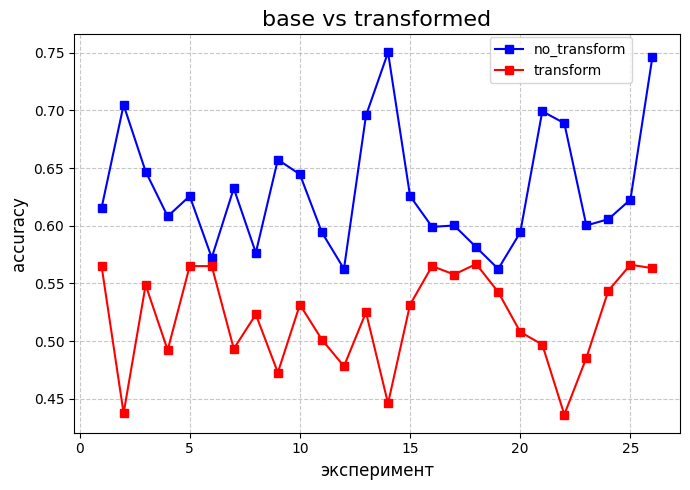

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 5))
x = np.arange(1, 27)
ax1.plot(x, accuracy_emb_1, label='no_transform', marker='s', linestyle='-', color='blue')
ax1.plot(x, accuracy_emb_1_trans, label='transform', marker='s', linestyle='-', color='red')
ax1.set_xlabel("эксперимент", fontsize=12)
ax1.set_ylabel("accuracy", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)
fig.legend(loc='upper right', bbox_to_anchor = (0.92, 0.93), fontsize=10)
plt.title('base vs transformed', fontsize=16)
plt.tight_layout()
plt.show()

прирост улучшился ли

In [ ]:
delta_trans = accuracy_concat_trans - np.vstack([accuracy_emb_1_trans, accuracy_emb_2]).max(axis = 0)
delta =  accuracy_concat - np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)

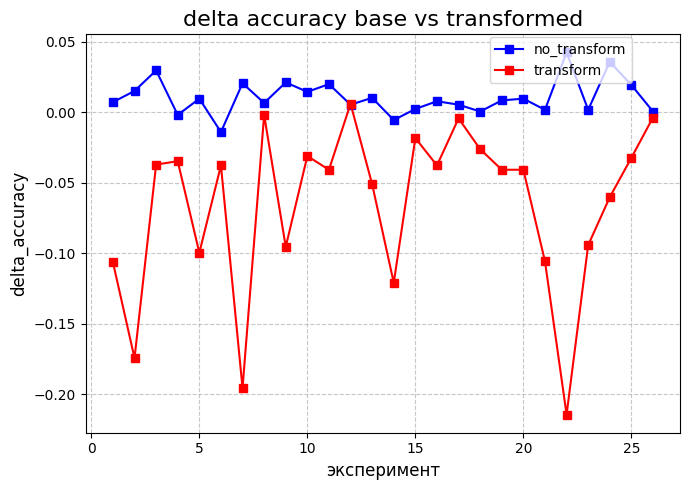

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 5))
x = np.arange(1, 27)
ax1.plot(x, delta, label='no_transform', marker='s', linestyle='-', color='blue')
ax1.plot(x, delta_trans, label='transform', marker='s', linestyle='-', color='red')
ax1.set_xlabel("эксперимент", fontsize=12)
ax1.set_ylabel("delta_accuracy", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)
fig.legend(loc='upper right', bbox_to_anchor = (0.92, 0.93), fontsize=10)
plt.title('delta accuracy base vs transformed', fontsize=16)
plt.tight_layout()
plt.show()

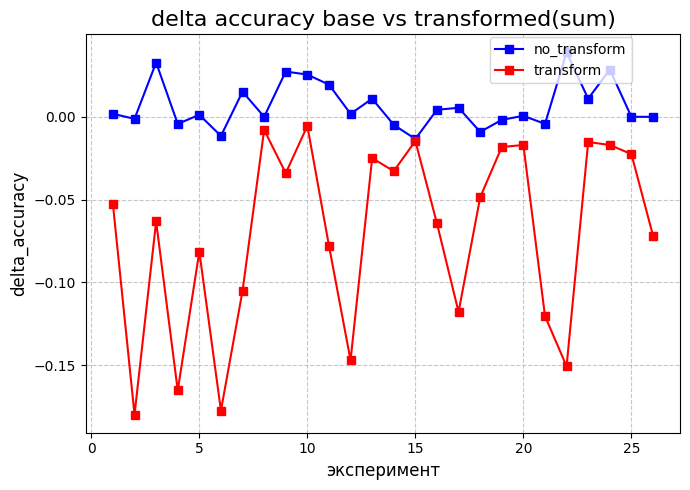

In [ ]:
delta_trans = accuracy_sum_trans - np.vstack([accuracy_emb_1_trans, accuracy_emb_2]).max(axis = 0)
delta =  accuracy_sum - np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)

fig, ax1 = plt.subplots(figsize=(7, 5))
x = np.arange(1, 27)
ax1.plot(x, delta, label='no_transform', marker='s', linestyle='-', color='blue')
ax1.plot(x, delta_trans, label='transform', marker='s', linestyle='-', color='red')
ax1.set_xlabel("эксперимент", fontsize=12)
ax1.set_ylabel("delta_accuracy", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)
fig.legend(loc='upper right', bbox_to_anchor = (0.92, 0.93), fontsize=10)
plt.title('delta accuracy base vs transformed(sum)', fontsize=16)
plt.tight_layout()
plt.show()

# Попробуем линейное преобразование и заодно поучить поменьше

In [ ]:
import torch.nn as nn

class EmbeddingTransformer_linear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim)
        self.double()

    def forward(self, X):
        return self.linear(X)

In [ ]:
# Предварительная загрузка данных в память
from tqdm import tqdm

data_pairs = []
for i in tqdm(range(1, 43)):
    if i ==19:
      continue
    train_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_A_{i}.csv').iloc[:,1:]
    train_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_B_{i}.csv').iloc[:,1:]

    embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    if (len(embed_columns)!=256) or (len(embed_columns_B)!=256):
      continue

    train_A = train_A.dropna(subset = ['gender'])
    train_B = train_B.dropna(subset = ['gender'])

    X_train_A = torch.tensor(train_A[embed_columns].values, device=device)
    X_train_B = torch.tensor(train_B[embed_columns_B].values, device=device)

    data_pairs.append((X_train_A, X_train_B))

100%|██████████| 42/42 [00:58<00:00,  1.39s/it]


In [ ]:
model = EmbeddingTransformer_linear(input_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Теперь в цикле обучения используем data_pairs из памяти
for epoch in range(10):
    total_loss = 0
    for X, Y in data_pairs:
        optimizer.zero_grad()
        X_transformed = model(X)
        loss = my_differentiable_metric(X_transformed, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(data_pairs)}")

Epoch 0, Loss: 0.277125397183545
Epoch 1, Loss: 0.17786665661751144
Epoch 2, Loss: 0.11767781215483354
Epoch 3, Loss: 0.08330932554251157
Epoch 4, Loss: 0.06153627639356721
Epoch 5, Loss: 0.045520906018298446
Epoch 6, Loss: 0.032841612848044904
Epoch 7, Loss: 0.022406700329432927
Epoch 8, Loss: 0.013586446474165915
Epoch 9, Loss: 0.005978075777444718


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_emb_modality/EmbeddingTransformer_lama_3.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_emb_modality/EmbeddingTransformer_lama_3.pt'

model = EmbeddingTransformer_linear(input_dim=256).to(device)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

EmbeddingTransformer_linear(
  (linear): Linear(in_features=256, out_features=256, bias=True)
)

In [ ]:
# Предварительная загрузка данных в память
from tqdm import tqdm

data_local = []
for i in tqdm(range(1, 43)):
    if i ==19:
      continue
    train_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_A_{i}.csv').iloc[:,1:]
    train_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/train_df_source_B_{i}.csv').iloc[:,1:]

    embed_columns = [x for x in train_A.columns if x.startswith("embed")]
    embed_columns_B = [x for x in train_B.columns if x.startswith("embed")]

    if (len(embed_columns)!=256) or (len(embed_columns_B)!=256):
      continue
    test_A = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_A_{i}.csv').iloc[:,1:]
    test_B = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_emb_modality/test_df_source_B_{i}.csv').iloc[:,1:]

    train_A = train_A.dropna(subset = ['gender'])
    test_A = test_A.dropna(subset = ['gender'])
    train_B = train_B.dropna(subset = ['gender'])
    test_B = test_B.dropna(subset = ['gender'])

    data_local.append((train_A, train_B, test_A, test_B))

100%|██████████| 42/42 [03:29<00:00,  4.99s/it]


In [ ]:
task = Task('binary')
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'gender'
roles = {
    'target': TARGET_NAME,
    'drop': ['customer_id']
}

In [ ]:
def compare_embeddings(emb1_train, emb1_test, emb2_train, emb2_test, calc_emb2 = True):

    # Метрики для оценки
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": f1_score,
        "ROC-AUC": roc_auc_score
    }
    y_test = emb2_test['gender'].values
    # Результаты
    results = {}

    # Обучаем и оцениваем на первом наборе эмбеддингов
    automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
    out_of_fold_predictions = automl.fit_predict(emb1_train, roles = roles, verbose = 0).data[:, 0]
    y_proba = automl.predict(emb1_test).data[:, 0]
    y_pred = (y_proba>0.5).astype(int)


    # Вычисляем метрики
    results["emb_1"] = {
        metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }

    # Обучаем и оцениваем на втором наборе эмбеддингов
    if calc_emb2:
        # Обучаем и оцениваем на первом наборе эмбеддингов
        automl = TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )
        out_of_fold_predictions = automl.fit_predict(emb2_train, roles = roles, verbose = 0).data[:, 0]
        y_proba = automl.predict(emb2_test).data[:, 0]
        y_pred = (y_proba>0.5).astype(int)


        # Вычисляем метрики
        results["emb_2"] = {
            metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
            for metric_name, metric_func in metrics.items()
        }


    # Создание новых наборов эмбеддингов

    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Сумма
      emb_sum_train = emb1_train + emb2_train
      emb_sum_test = emb1_test + emb2_test
      emb_sum_train['gender'] = emb_sum_train['gender'].apply(lambda x: 1 if x ==2 else x)
      emb_sum_test['gender'] = emb_sum_test['gender'].apply(lambda x: 1 if x ==2 else x)

    if emb1_train.shape[1] == emb2_train.shape[1]:
      # Обучаем и оцениваем на сумме эмбеддингов
          automl = TabularAutoML(
          task = task,
          timeout = TIMEOUT,
          cpu_limit = N_THREADS,
          reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
      )
          out_of_fold_predictions = automl.fit_predict(emb1_train, roles = roles, verbose = 0).data[:, 0]
          y_proba = automl.predict(emb1_test).data[:, 0]
          y_pred = (y_proba>0.5).astype(int)

      # Вычисляем метрики
          results["sum_emb"] = {
              metric_name: metric_func(y_test, y_pred if metric_name != "ROC-AUC" else y_proba)
              for metric_name, metric_func in metrics.items()
          }

    return results

In [ ]:
try:
  with open('/content/drive/MyDrive/PTLS/ensemble/metric_transform_lama_3.pickle', 'rb') as handle:
      results = pickle.load(handle)
except:
  results = {}

In [ ]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
# 4ч 11 мин
for i, (train_A, train_B, test_A, test_B) in enumerate(data_local[16:], 17):

    results[i] = {}

    # преобразовываем 1й эмбеддинг
    with torch.no_grad():
      new_emb = model(torch.tensor(train_A.iloc[:, :256].values, device = device))
    train_A.iloc[:, :256] = new_emb.cpu().numpy()


    #Сравниваем 2 набора по качеству
    res_comp = compare_embeddings(train_A, test_A, train_B, test_B, calc_emb2 = False)
    clear_output()
    print(f'Эксперимент {i}')
    print(res_comp)
    results[i] = res_comp


    with open('/content/drive/MyDrive/PTLS/data_emb_modality/metric_transform_lama_3.pickle', 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Эксперимент 27
{'emb_1': {'Accuracy': 0.44106925880923453, 'F1 Score': 0.5993031358885017, 'ROC-AUC': 0.5032167958190665}, 'sum_emb': {'Accuracy': 0.44106925880923453, 'F1 Score': 0.5993031358885017, 'ROC-AUC': 0.5074990989367454}}


# Результаты преобразования

In [ ]:
with open('/content/drive/MyDrive/PTLS/data_emb_modality/results_lama_2.pickle', 'rb') as handle:
    results_1 = pickle.load(handle)

rng = results_1.keys()

with open('/content/drive/MyDrive/PTLS/data_emb_modality/metric_transform_lama_3.pickle', 'rb') as handle:
    results_2 = pickle.load(handle)

In [ ]:
results_2[19]

{'emb_1': {'Accuracy': 0.46537059538274606,
  'F1 Score': 0.5253505933117584,
  'ROC-AUC': 0.4902857872289301},
 'sum_emb': {'Accuracy': 0.46111786148238154,
  'F1 Score': 0.5202812330989725,
  'ROC-AUC': 0.48996590977353277}}

In [ ]:
metric = 'Accuracy'

accuracy_emb_1 = np.array([results_1[i]['compare_embs']['emb_1'][metric] for i in rng])
accuracy_emb_1_trans = np.array([results_2[i]['emb_1'][metric] for i in rng])
accuracy_emb_2= np.array([results_1[i]['compare_embs']['emb_2'][metric] for i in rng])

accuracy_sum = np.array([results_1[i]['compare_embs']['sum_emb'][metric] if results_1[i]['compare_embs'].get('sum_emb') else np.nan for i in rng])

accuracy_sum_trans = np.array([results_2[i]['sum_emb'][metric] if results_2[i].get('sum_emb') else np.nan for i in rng])

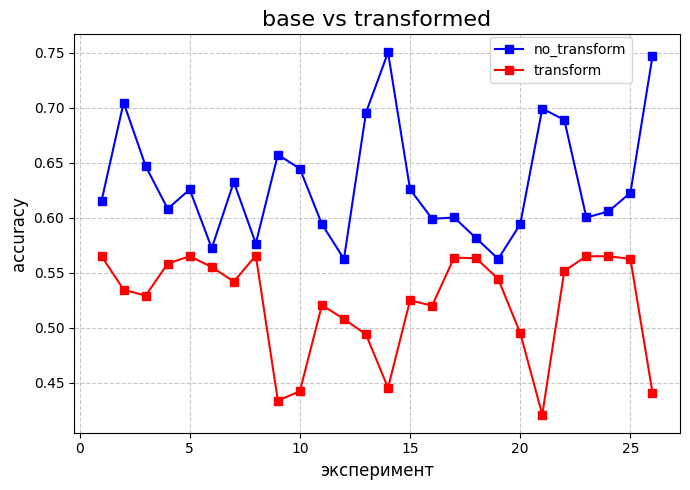

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 5))
x = np.arange(1, 27)
ax1.plot(x, accuracy_emb_1, label='no_transform', marker='s', linestyle='-', color='blue')
ax1.plot(x, accuracy_emb_1_trans, label='transform', marker='s', linestyle='-', color='red')
ax1.set_xlabel("эксперимент", fontsize=12)
ax1.set_ylabel("accuracy", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)
fig.legend(loc='upper right', bbox_to_anchor = (0.92, 0.93), fontsize=10)
plt.title('base vs transformed', fontsize=16)
plt.tight_layout()
plt.show()

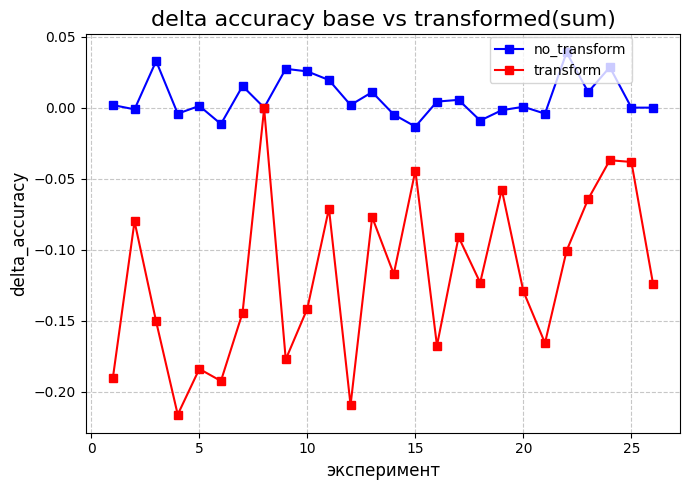

In [ ]:
delta_trans = accuracy_sum_trans - np.vstack([accuracy_emb_1_trans, accuracy_emb_2]).max(axis = 0)
delta =  accuracy_sum - np.vstack([accuracy_emb_1, accuracy_emb_2]).max(axis = 0)

fig, ax1 = plt.subplots(figsize=(7, 5))
x = np.arange(1, 27)
ax1.plot(x, delta, label='no_transform', marker='s', linestyle='-', color='blue')
ax1.plot(x, delta_trans, label='transform', marker='s', linestyle='-', color='red')
ax1.set_xlabel("эксперимент", fontsize=12)
ax1.set_ylabel("delta_accuracy", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)
fig.legend(loc='upper right', bbox_to_anchor = (0.92, 0.93), fontsize=10)
plt.title('delta accuracy base vs transformed(sum)', fontsize=16)
plt.tight_layout()
plt.show()